# Implementace numerických integrátorů

V této části budeme vyšetřovat odezvu obyčejného matematického kyvadla. To je řízeno následující diferenciální rovnicí

$$
\ddot{\varphi} = -\frac{g}{l}\sin\varphi.
$$

Pro použití našich integrátorů je vhodné tuto rovnici převést na soustavu dvou rovnic 1. řádu. Dostáváme tedy

$$
\dot{\varphi} = \xi, \\
\dot{\xi} = -\frac{g}{l}\sin\varphi.
$$

Tato soustava popisuje kyvadlo při libovolné výchylce. V mnoha ohledech se jeví jako výhodné občas linearizovat tuto soustavu. Ta je pak přesná jen pro malé výchylky. Tato linearizovaná soustava je rovna

$$
\dot{\varphi} = \xi, \\
\dot{\xi} = -\frac{g}{l}\varphi.
$$

## Implementace

Nejprve si do pythonu načteme všechny potřebné knihovny.

In [151]:
import numpy as np
import math as ma
import matplotlib.pyplot as plt

Následně vytvoříme funkci, která spočte náš problém dopřednou Eulerovou metodou. 

In [152]:
def forward_euler(times_i, x_first, v_first, problem):
    solution1 = [x_first]
    solution2 = [v_first]
    v_old = v_first
    x_old = x_first
    dt = abs(times_i[1] - times_i[0])
    energy_kin = [0]
    energy_pot = [0]
    for ts in times_i[1:]:
        if problem == "pendulum":
            v_new = v_old - dt*g/l*ma.sin(x_old)
            x_new = x_old + dt*v_old
        elif problem == "pendulum_lin":
            v_new = v_old - dt*g/l*(x_old)
            x_new = x_old + dt*v_old
        solution1.append(x_new)
        solution2.append(v_new)
        energy_kin.append(0.5*m*l**2*v_new**2)
        energy_pot.append(m*g*l*(1-ma.cos(x_new)))

        v_old = v_new
        x_old = x_new

    return solution1, solution2, np.array(energy_kin), np.array(energy_pot)

Tuto jednoduchou utilitku můžeme ihned využít ke zkoumání vlastností vytvořeného integrátoru. O dopředné Eulerově metodě se ví, že má špatné vlastnosti. Naproti tomu se ale jedná o explicitní metodu, což je někdy výhodné. Pojďme se podívat co nám z toho leze numericky. Pojďme pro námi zvolené parametry vyšetřovat, jak se mění odezva systému při zjemňování časového kroku.

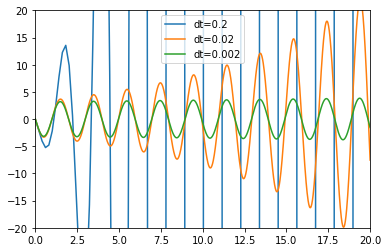

In [153]:
# Parameters
m = 1.0
k = 1.0
g = 10.0
l = 1.0

times_1 = np.linspace(0, 20, 100)
fe1_1, fe1_2, ke1, pe1 = forward_euler(times_1, 1.0, 0.0, "pendulum_lin")

times_2 = np.linspace(0, 20, 1000)
fe2_1, fe2_2, ke2, pe2 = forward_euler(times_2, 1.0, 0.0, "pendulum_lin")

times_3 = np.linspace(0, 20, 10000)
fe3_1, fe3_2, ke3, pe3 = forward_euler(times_3, 1.0, 0.0, "pendulum_lin")

plt.plot(times_1, fe1_2, label="dt=0.2")
plt.plot(times_2, fe2_2, label="dt=0.02")
plt.plot(times_3, fe3_2, label="dt=0.002")
plt.ylim(-20, 20)
plt.xlim(0, 20)
plt.legend()
plt.show()

Je vidět, že při hrubém časovém kroku začne dopředný Euler předpovídat neuspokojivě velké hodnoty. Pokud zjemňujeme, je odezva lepší. Nicméně ve skutečnosti pro jakýkoliv časový krok se tato metoda vždy rozkmitává stále více a nakonec roste nade všechny meze. Je to vidět i z analýzy energií tohoto systému.

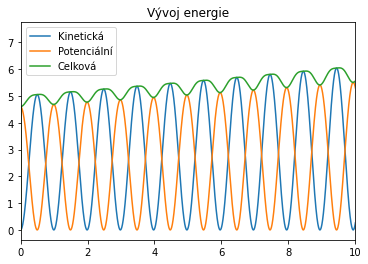

In [154]:
plt.title("Vývoj energie")
plt.plot(times_3, ke3, label="Kinetická")
plt.plot(times_3, pe3, label="Potenciální")
plt.plot(times_3, ke3 + pe3, label="Celková")
plt.xlim(0, 10)
plt.legend()
plt.show()

Celková energie má vždy nenulový sklon a postupně roste. Numerika tedy do systému přidává stále novou energii. Tento integrátor tedy není vhodný pro popis takových harmonických systému, neboť v dlouhých časech nedokáže jejich chování popsat kvalitativně správně. Tento fenomén je problematický ještě více u rovnice nelinearizovaného kyvadla, neboť vždy dojde k "prolomení" úhlů, kdy se kyvadlo hýbe jen maximálně o půl otočky. Je to vidět v následující numerické simulaci.

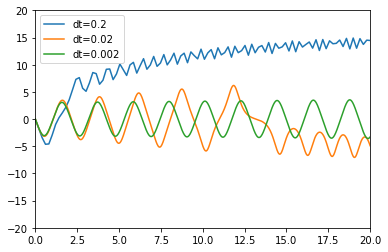

In [155]:
times_1 = np.linspace(0, 20, 100)
fe1_1, fe1_2, ke1, pe1 = forward_euler(times_1, 1.0, 0.0, "pendulum")

times_2 = np.linspace(0, 20, 1000)
fe2_1, fe2_2, ke2, pe2 = forward_euler(times_2, 1.0, 0.0, "pendulum")

times_3 = np.linspace(0, 20, 10000)
fe3_1, fe3_2, ke3, pe3 = forward_euler(times_3, 1.0, 0.0, "pendulum")

plt.plot(times_1, fe1_2, label="dt=0.2")
plt.plot(times_2, fe2_2, label="dt=0.02")
plt.plot(times_3, fe3_2, label="dt=0.002")
plt.ylim(-20, 20)
plt.xlim(0, 20)
plt.legend()
plt.show()

Zde již dochází k výrazné kvalitativní změně odezvy. A opět i energie roste postupně nade všechny meze.

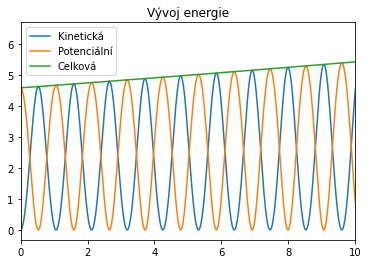

In [156]:
plt.title("Vývoj energie")
plt.plot(times_3, ke3, label="Kinetická")
plt.plot(times_3, pe3, label="Potenciální")
plt.plot(times_3, ke3 + pe3, label="Celková")
plt.xlim(0, 10)
plt.legend()
plt.show()

Podobně můžeme analyzovat i zpětného Eulera. Zde už nastává první potíž, neboť rovnice pro další časový krok je implicitní a neznámé nemůžou být v uzavřeném tvaru vyjádřeny. Proto je nutné využít nějakou další numerickou metodu. V našem případě používáme <code>scipy.optimize.root_scalar</code> pro hledání koření skalární rovnice.

In [145]:
from scipy import optimize

def backward_euler(times_i, x_first, v_first, problem):
    solution1 = [x_first]
    solution2 = [v_first]
    v_old = v_first
    x_old = x_first
    dt = times_i[1] - times_i[0]
    energy_kin = [0]
    energy_pot = [0]
    for ts in times_i[1:]:
        if problem == "pendulum":
            def f(x):
                return x + dt**2*g/l*ma.sin(x) - x_old - dt*v_old
            x_new = optimize.root_scalar(f, x0=0.0, bracket=[-30, 30], method="brentq").root
            v_new = v_old - dt*g/l*ma.sin(x_new)
        elif problem == "pendulum_lin":
            fact = 1/(1 + dt**2*g/l)
            v_new = (v_old - dt*g/l*x_old)*fact
            x_new = (x_old + dt*v_old)*fact
        solution1.append(x_new)
        solution2.append(v_new)
        energy_kin.append(0.5*m*l**2*v_new**2)
        energy_pot.append(m*g*l*(1-ma.cos(x_new)))
        v_old = v_new
        x_old = x_new
    return solution1, solution2, np.array(energy_kin), np.array(energy_pot)

A opět můžeme řešič pustit pro různé časové kroky.

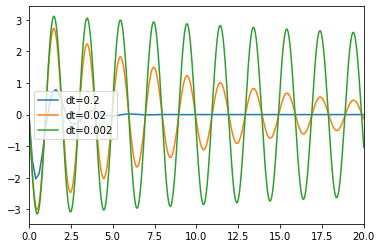

In [157]:
# Parameters
m = 1.0
k = 1.0
g = 10.0
l = 1.0

times_1 = np.linspace(0, 20, 100)
fe1_1, fe1_2, ke1, pe1 = backward_euler(times_1, 1.0, 0.0, "pendulum_lin")

times_2 = np.linspace(0, 20, 1000)
fe2_1, fe2_2, ke2, pe2 = backward_euler(times_2, 1.0, 0.0, "pendulum_lin")

times_3 = np.linspace(0, 20, 10000)
fe3_1, fe3_2, ke3, pe3 = backward_euler(times_3, 1.0, 0.0, "pendulum_lin")

plt.plot(times_1, fe1_2, label="dt=0.2")
plt.plot(times_2, fe2_2, label="dt=0.02")
plt.plot(times_3, fe3_2, label="dt=0.002")
#plt.ylim(-20, 20)
plt.xlim(0, 20)
plt.legend()
plt.show()

Zde je vidět zcela obrácený fenomén - naše řešení je numerickou metodou tlumeno a amplituda řešení se stále snižuje. U jemného kroku sice není viditelná, ale numerický útlum je stále přítomen. Je to opět hezky vidět z energetického diagramu, kde je vidět, že celková energie klesá.

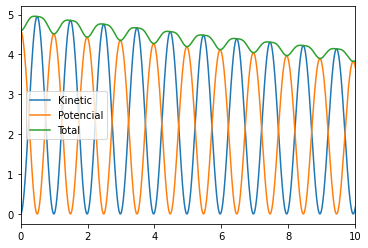

In [158]:
plt.plot(times_3, ke3, label="Kinetic")
plt.plot(times_3, pe3, label="Potencial")
plt.plot(times_3, ke3 + pe3, label="Total")
plt.xlim(0, 10)
plt.legend()
plt.show()

Podobně můžeme vyřešit i nelineární rovnici pro kyvadlo, zde se toho moc nemění oproti lineární verzi.

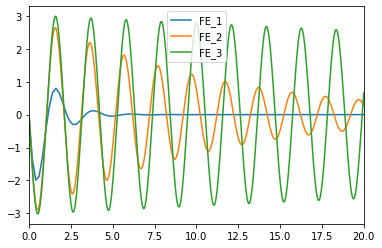

In [159]:
times_1 = np.linspace(0, 20, 100)
fe1_1, fe1_2, ke1, pe1 = backward_euler(times_1, 1.0, 0.0, "pendulum")

times_2 = np.linspace(0, 20, 1000)
fe2_1, fe2_2, ke2, pe2 = backward_euler(times_2, 1.0, 0.0, "pendulum")

times_3 = np.linspace(0, 20, 10000)
fe3_1, fe3_2, ke3, pe3 = backward_euler(times_3, 1.0, 0.0, "pendulum")

plt.plot(times_1, fe1_2, label="FE_1")
plt.plot(times_2, fe2_2, label="FE_2")
plt.plot(times_3, fe3_2, label="FE_3")
#plt.ylim(-20, 20)
plt.xlim(0, 20)
plt.legend()
plt.show()

A energie opět klesá.

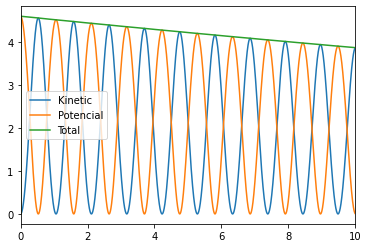

In [160]:
plt.plot(times_3, ke3, label="Kinetic")
plt.plot(times_3, pe3, label="Potencial")
plt.plot(times_3, ke3 + pe3, label="Total")
plt.xlim(0, 10)
plt.legend()
plt.show()